In [1]:
pip install torch datasets

  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached huggingface_hub-0.27.0-py3-none-any.whl.metadata (13 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached frozenlist-1.5.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached multidict-6.1.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.0 kB)
  Using cached propcache-0.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.2 kB)
  Using cached yarl-1.18.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (69 kB)
Using cached datasets-3.2.0-py3-none-any.whl (480 kB)
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
pip install transformers

  Using cached transformers-4.47.1-py3-none-any.whl.metadata (44 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached transformers-4.47.1-py3-none-any.whl (10.1 MB)
Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)
Using cached safetensors-0.4.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (435 kB)
Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import timm
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn, optim
from tqdm import tqdm
import os
import shutil

# Gerät konfigurieren
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Bildvorverarbeitung definieren
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ändert die Größe des Bildes
    transforms.ToTensor(),          # Konvertiert zu Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisierung
])

# Funktion, um unerwünschte Verzeichnisse zu entfernen
def clean_directories(directory):
    for root, dirs, _ in os.walk(directory):
        for dir_name in dirs:
            if dir_name.startswith("."):  # Versteckte Verzeichnisse wie .ipynb_checkpoints
                shutil.rmtree(os.path.join(root, dir_name))

# Daten bereinigen
train_dir = "./vehicles/train"
test_dir = "./vehicles/test"
clean_directories(train_dir)
clean_directories(test_dir)

# Daten laden
train_dataset = datasets.ImageFolder(
    train_dir,
    transform=transform,
    is_valid_file=lambda x: os.path.splitext(x)[1].lower() in [".jpg", ".jpeg", ".png", ".bmp"]
)

test_dataset = datasets.ImageFolder(
    test_dir,
    transform=transform,
    is_valid_file=lambda x: os.path.splitext(x)[1].lower() in [".jpg", ".jpeg", ".png", ".bmp"]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modell laden und anpassen
model_name = "efficientnet_b0"
model = timm.create_model(model_name, pretrained=True, num_classes=len(train_dataset.classes))
model.to(device)

# Verlustfunktion und Optimierer definieren
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trainingsfunktion
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}")

# Testfunktion
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Modell trainieren und testen
train_model(model, train_loader, criterion, optimizer, device, epochs=5)
test_model(model, test_loader, device)


Training Epoch 1/5: 100%|██████████| 12/12 [09:02<00:00, 45.24s/it]


Epoch 1, Loss: 1.5523


Training Epoch 2/5: 100%|██████████| 12/12 [08:56<00:00, 44.68s/it]


Epoch 2, Loss: 0.2187


Training Epoch 3/5: 100%|██████████| 12/12 [08:57<00:00, 44.79s/it]


Epoch 3, Loss: 0.2387


Training Epoch 4/5: 100%|██████████| 12/12 [08:49<00:00, 44.08s/it]


Epoch 4, Loss: 0.1056


Training Epoch 5/5: 100%|██████████| 12/12 [08:38<00:00, 43.21s/it]


Epoch 5, Loss: 0.0469


Testing: 100%|██████████| 2/2 [01:00<00:00, 30.25s/it]

Test Accuracy: 82.61%


Processing Test Data: 100%|██████████| 2/2 [00:59<00:00, 29.91s/it]


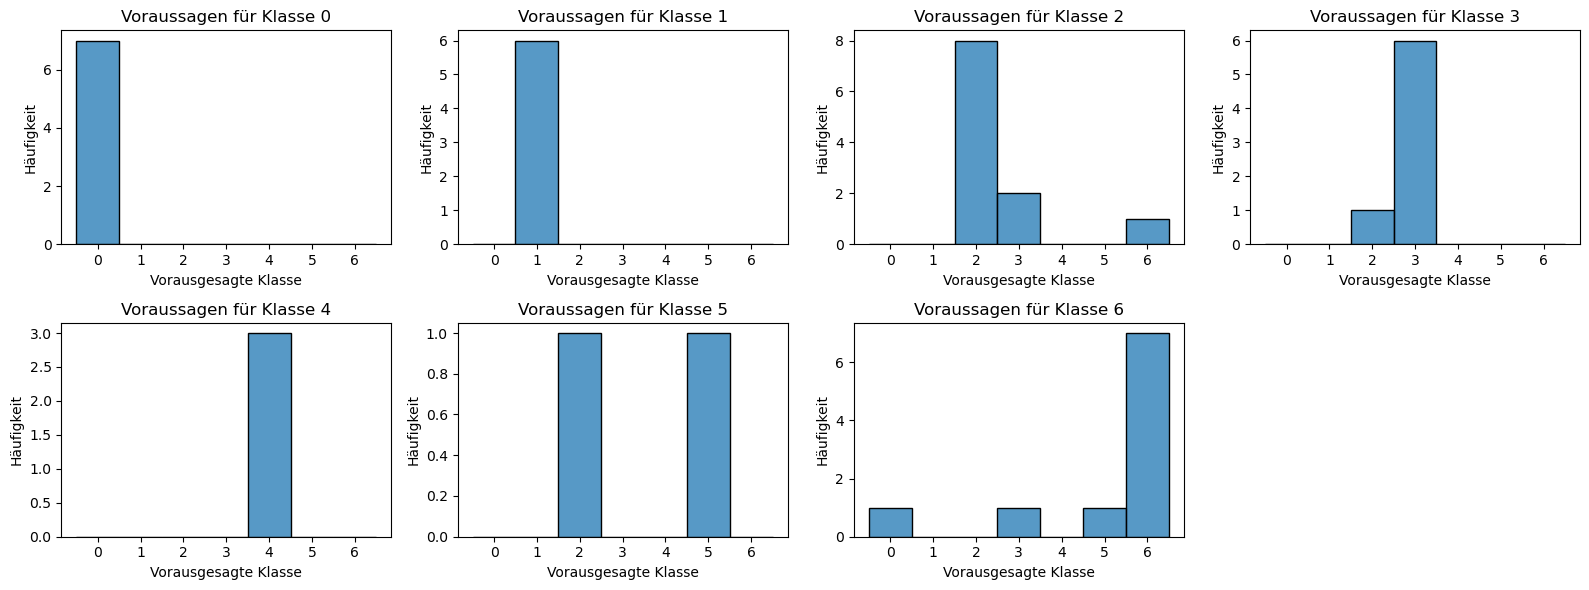

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Bereite die Testdaten vor (falls noch nicht passiert)
test_images = []
test_labels = []

for images, labels in tqdm(test_loader, desc="Processing Test Data"):
    test_images.append(images)
    test_labels.append(labels)

test_images = torch.cat(test_images).to(device)
test_labels = torch.cat(test_labels).to(device)

# Vorhersagen für die Testdaten
model.eval()
with torch.no_grad():
    outputs = model(test_images)
    predictions = outputs.cpu().numpy()

# Konvertiere One-Hot-Encoded Labels in eindimensionale Labels
true_labels = test_labels.cpu().numpy()

# Extrahiere die vorhergesagten Klassen (höchste Wahrscheinlichkeit)
predicted_labels = np.argmax(predictions, axis=1)

# Erstelle den DataFrame
results_df = pd.DataFrame({
    'True Label': true_labels,
    'Predicted Label': predicted_labels
})

# Plot der Vorhersagen nach Klassen
plt.figure(figsize=(16, 6))
num_classes = len(train_dataset.classes)  # Anzahl der Klassen aus dem Trainingsdatensatz
for i in range(num_classes):
    plt.subplot(2, (num_classes + 1) // 2, i + 1)
    sns.histplot(results_df[results_df['True Label'] == i]['Predicted Label'], bins=np.arange(num_classes + 1) - 0.5)
    plt.title(f'Voraussagen für Klasse {i}')
    plt.xlabel('Vorausgesagte Klasse')
    plt.ylabel('Häufigkeit')
    plt.xticks(range(num_classes))
plt.tight_layout()
plt.show()
